In [19]:
# Step 0: Essential imports for ensemble model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
import scipy.optimize

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, Bidirectional,
    LayerNormalization, MultiHeadAttention, Flatten, Concatenate, Input,
    Conv1D, MaxPooling1D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_self_attention import SeqSelfAttention
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

print("🚀 Ensemble Environment setup complete!")
print(f"TensorFlow version: {tf.__version__}")

🚀 Ensemble Environment setup complete!
TensorFlow version: 2.18.0


In [20]:
# Step 1: Load and prepare base data
print("📊 Loading data from data_with_discharge.csv...")
# Make sure 'data_with_discharge.csv' is in the same directory as this notebook.
data = pd.read_csv('data_with_discharge.csv')
print(f"Original data shape: {data.shape}")

# Convert Date
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True, errors='raise')
data = data.sort_values('Date').reset_index(drop=True)

# Basic data info
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")
print(f"Data shape after date conversion: {data.shape}")

📊 Loading data from data_with_discharge.csv...
Original data shape: (1770, 182)
Date range: 2000-07-31 00:00:00 to 2014-09-30 00:00:00
Data shape after date conversion: (1770, 182)


In [21]:
print("🔄 Creating consistent data splits...")

# Split data: 70% train, 20% test, 10% validation
n_total = len(data)
train_size = int(0.7 * n_total)
test_size = int(0.2 * n_total)
val_size = n_total - train_size - test_size

# Create individual splits
data_train = data.iloc[:train_size].copy()
data_test = data.iloc[train_size:train_size + test_size].copy()
data_val = data.iloc[train_size + test_size:].copy()

# Merge validation into test set
data_test_full = pd.concat([data_test, data_val], axis=0).reset_index(drop=True)

print(f"Train set: {len(data_train)} samples ({data_train['Date'].min()} to {data_train['Date'].max()})\n")
print(f"Test set (incl. val): {len(data_test_full)} samples ({data_test_full['Date'].min()} to {data_test_full['Date'].max()})\n")
print(f"Validation set: {len(data_val)} samples ({data_val['Date'].min()} to {data_val['Date'].max()})")


🔄 Creating consistent data splits...
Train set: 1239 samples (2000-07-31 00:00:00 to 2010-08-18 00:00:00)

Test set (incl. val): 531 samples (2010-08-19 00:00:00 to 2014-09-30 00:00:00)

Validation set: 177 samples (2013-08-07 00:00:00 to 2014-09-30 00:00:00)


In [22]:
# Step 3: Feature engineering for ML models with LOG TRANSFORM
def prepare_ml_features(data_split, feature_type='krr'):
    """Prepare features for ML models, now using log-transformed target."""
    data = data_split.copy()
    rainfall_columns = [col for col in data.columns if col.startswith('L')]
    target_column = 'Inflow (cumecs)'
    log_target_column = 'log_inflow'

    # Apply log transform to target. Use log1p to handle zeros.
    data[log_target_column] = np.log1p(data[target_column])

    # Replace 0s in features
    for col in rainfall_columns:
        data[col] = data[col].replace(0, 0.01)
    if 'discharge_mean' in data.columns:
        data['discharge_mean'] = data['discharge_mean'].fillna(0.01).replace(0, 0.01)


    data['mean_rainfall'] = data[rainfall_columns].mean(axis=1)
    # Create lags on the LOG-TRANSFORMED inflow
    lag_list = [1, 2, 3, 5, 7, 10, 14, 21, 30]
    for lag in lag_list:
        data[f'inflow_lag_{lag}'] = data[log_target_column].shift(lag)

    # Cyclical features
    data['day_of_year'] = data['Date'].dt.dayofyear
    data['month'] = data['Date'].dt.month
    data['day_of_year_sin'] = np.sin(2 * np.pi * data['day_of_year'] / 366)
    data['day_of_year_cos'] = np.cos(2 * np.pi * data['day_of_year'] / 366)
    data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
    data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

    data = data.dropna().reset_index(drop=True)

    cyclical_features = ['day_of_year_sin', 'day_of_year_cos', 'month_sin', 'month_cos']
    lag_features = [f'inflow_lag_{lag}' for lag in lag_list]

    if feature_type == 'krr':
        feature_columns = ['mean_rainfall'] + lag_features + cyclical_features
    elif feature_type == 'xgb':
        feature_columns = ['mean_rainfall', 'discharge_mean'] + lag_features + cyclical_features

    # Return the original target for evaluation and the log target for training
    return data, feature_columns, target_column, log_target_column

print("🔄 Preparing ML features with log transform...")
train_krr, krr_features, target_col, log_target_col = prepare_ml_features(data_train, 'krr')
test_krr, _, _, _ = prepare_ml_features(data_test, 'krr')
val_krr, _, _, _ = prepare_ml_features(data_val, 'krr')

train_xgb, xgb_features, _, _ = prepare_ml_features(data_train, 'xgb')
test_xgb, _, _, _ = prepare_ml_features(data_test, 'xgb')
val_xgb, _, _, _ = prepare_ml_features(data_val, 'xgb')


print(f"KRR features: {len(krr_features)} features")
print(f"XGBoost features: {len(xgb_features)} features")

🔄 Preparing ML features with log transform...
KRR features: 14 features
XGBoost features: 15 features


In [23]:
# Step 4: Prepare ML datasets and scale features
print("🔄 Preparing and scaling ML datasets...\n")

X_train_krr, y_train_krr_log = train_krr[krr_features].values, train_krr[log_target_col].values
X_test_krr, y_test_krr_actual = test_krr[krr_features].values, test_krr[target_col].values
X_val_krr, y_val_krr_actual = val_krr[krr_features].values, val_krr[target_col].values

X_train_xgb, y_train_xgb_log = train_xgb[xgb_features].values, train_xgb[log_target_col].values
X_test_xgb, y_test_xgb_actual = test_xgb[xgb_features].values, test_xgb[target_col].values
X_val_xgb, y_val_xgb_actual = val_xgb[xgb_features].values, val_xgb[target_col].values

krr_scaler = RobustScaler()
X_train_krr_scaled = krr_scaler.fit_transform(X_train_krr)
X_test_krr_scaled = krr_scaler.transform(X_test_krr)
X_val_krr_scaled = krr_scaler.transform(X_val_krr)

xgb_scaler = RobustScaler()
X_train_xgb_scaled = xgb_scaler.fit_transform(X_train_xgb)
X_test_xgb_scaled = xgb_scaler.transform(X_test_xgb)
X_val_xgb_scaled = xgb_scaler.transform(X_val_xgb)

print("✅ Datasets prepared. Models will be trained on log-transformed target.")

🔄 Preparing and scaling ML datasets...

✅ Datasets prepared. Models will be trained on log-transformed target.


In [24]:
# Step 5: Train and evaluate KRR model
print("🔄 Training KRR model on log-transformed data...")

def calculate_metrics(y_true, y_pred, model_name, set_name):
    """Calculate comprehensive metrics"""
    mean_observed = np.mean(y_true)
    nse = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - mean_observed) ** 2))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rsr = rmse / np.std(y_true)

    print(f"\n{model_name} - {set_name} Set Metrics:")
    print(f"NSE: {nse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"RSR: {rsr:.4f}")
    return {'NSE': nse, 'RMSE': rmse, 'RSR': rsr}

krr_model = KernelRidge(kernel='rbf', alpha=0.1, gamma=0.01)
krr_model.fit(X_train_krr_scaled, y_train_krr_log)

# Predict in log space
krr_pred_test_log = krr_model.predict(X_test_krr_scaled)
krr_pred_val_log = krr_model.predict(X_val_krr_scaled)

# Inverse transform to original scale for evaluation
krr_pred_test = np.expm1(krr_pred_test_log)
krr_pred_val = np.expm1(krr_pred_val_log)

krr_test_metrics = calculate_metrics(y_test_krr_actual, krr_pred_test, "KRR", "Test")
krr_val_metrics = calculate_metrics(y_val_krr_actual, krr_pred_val, "KRR", "Validation")

print("\n✅ KRR model training and evaluation completed")
joblib.dump(krr_model, "krr_model.pkl")

🔄 Training KRR model on log-transformed data...

KRR - Test Set Metrics:
NSE: 0.7717
RMSE: 1741.7293
RSR: 0.4778

KRR - Validation Set Metrics:
NSE: 0.7050
RMSE: 2006.2681
RSR: 0.5431

✅ KRR model training and evaluation completed


['krr_model.pkl']

In [25]:
# Step 6: Train and evaluate XGBoost model with CUSTOM PEAK OBJECTIVE
print("🔄 Training XGBoost model with custom peak-focused objective...\n")

# Define the custom objective function for XGBoost
def peak_focused_objective(y_true, y_pred):
    """Custom objective for XGBoost to focus on peaks."""
    peak_weight = 20.0 # Weight for peak errors
    residual = y_true - y_pred

    # Define peaks as top 10% of true values
    peak_threshold = np.quantile(y_true, 0.90)
    weights = np.where(y_true >= peak_threshold, peak_weight, 1.0)

    # Gradient (first derivative)
    grad = -2.0 * weights * residual
    # Hessian (second derivative)
    hess = 2.0 * weights

    return grad, hess

xgb_model = xgb.XGBRegressor(
    # Use the custom objective function
    obj=peak_focused_objective,
    learning_rate=0.05,
    max_depth=7,
    n_estimators=300,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
# Train on log-transformed data
xgb_model.fit(X_train_xgb_scaled, y_train_xgb_log)

# Predict in log space
xgb_pred_test_log = xgb_model.predict(X_test_xgb_scaled)
xgb_pred_val_log = xgb_model.predict(X_val_xgb_scaled)

# Inverse transform for evaluation
xgb_pred_test = np.expm1(xgb_pred_test_log)
xgb_pred_val = np.expm1(xgb_pred_val_log)

xgb_test_metrics = calculate_metrics(y_test_xgb_actual, xgb_pred_test, "XGBoost (Peak-Focused)", "Test")
xgb_val_metrics = calculate_metrics(y_val_xgb_actual, xgb_pred_val, "XGBoost (Peak-Focused)", "Validation")

print("\n✅ XGBoost model training and evaluation completed")
joblib.dump(xgb_model, "xgb_model.pkl")

🔄 Training XGBoost model with custom peak-focused objective...


XGBoost (Peak-Focused) - Test Set Metrics:
NSE: 0.7561
RMSE: 1800.1054
RSR: 0.4938

XGBoost (Peak-Focused) - Validation Set Metrics:
NSE: 0.8118
RMSE: 1602.5891
RSR: 0.4338

✅ XGBoost model training and evaluation completed


['xgb_model.pkl']

In [26]:
# Step 7: Create ML ensemble (average of KRR and XGBoost)
print("🔄 Creating ML ensemble...\n")

min_test_len = min(len(krr_pred_test), len(xgb_pred_test))
min_val_len = min(len(krr_pred_val), len(xgb_pred_val))

# Average the predictions (which are now on the original scale)
ml_ensemble_test = (krr_pred_test[:min_test_len] + xgb_pred_test[:min_test_len]) / 2
ml_ensemble_val = (krr_pred_val[:min_val_len] + xgb_pred_val[:min_val_len]) / 2

y_test_ml_ensemble = y_test_krr_actual[:min_test_len]
y_val_ml_ensemble = y_val_krr_actual[:min_val_len]

ml_ensemble_test_metrics = calculate_metrics(y_test_ml_ensemble, ml_ensemble_test, "ML Ensemble (KRR+XGB)", "Test")
ml_ensemble_val_metrics = calculate_metrics(y_val_ml_ensemble, ml_ensemble_val, "ML Ensemble (KRR+XGB)", "Validation")

print("\n✅ ML ensemble evaluation completed")

🔄 Creating ML ensemble...


ML Ensemble (KRR+XGB) - Test Set Metrics:
NSE: 0.7957
RMSE: 1647.6246
RSR: 0.4520

ML Ensemble (KRR+XGB) - Validation Set Metrics:
NSE: 0.8062
RMSE: 1626.3642
RSR: 0.4403

✅ ML ensemble evaluation completed


In [27]:
# Step 8: Prepare LSTM data (REMOVED Blackman smoothing)
def prepare_lstm_data_log(data_split, n_steps_in=30, n_steps_out=5):
    """Prepare LSTM sequences using log-transform and NO smoothing."""
    data = data_split.copy()
    data_numeric = data.drop(['Date'], axis=1)
    for col in data_numeric.columns:
        data_numeric[col] = data_numeric[col].replace(0, 0.01).fillna(0.01)

    # Log transform the target variable
    target_col = 'Inflow (cumecs)'
    data_numeric[target_col] = np.log1p(data_numeric[target_col])

    # Scale ALL features
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data_numeric), columns=data_numeric.columns)

    # Create sequences
    X, y = [], []
    target_idx = data_numeric.columns.get_loc(target_col)
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        seq_x = data_scaled.iloc[i:(i + n_steps_in)].values
        seq_y = data_scaled.iloc[(i + n_steps_in):(i + n_steps_in + n_steps_out), target_idx].values
        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y), scaler, data_numeric

print("🔄 Preparing LSTM data for Hybrid Attention model (log-transformed, no smoothing)...\n")
X_lstm_train, y_lstm_train_log, lstm_scaler, train_numeric_log = prepare_lstm_data_log(data_train)

# Transform test and val data using the scaler from the training set
def transform_lstm_data_log(data_split, scaler, n_steps_in=30, n_steps_out=5):
    data = data_split.copy()
    data_numeric = data.drop(['Date'], axis=1)
    for col in data_numeric.columns:
        data_numeric[col] = data_numeric[col].replace(0, 0.01).fillna(0.01)
    target_col = 'Inflow (cumecs)'
    data_numeric[target_col] = np.log1p(data_numeric[target_col])
    data_scaled = pd.DataFrame(scaler.transform(data_numeric), columns=data_numeric.columns)
    X, y = [], []
    target_idx = data_numeric.columns.get_loc(target_col)
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        X.append(data_scaled.iloc[i:(i + n_steps_in)].values)
        y.append(data_scaled.iloc[(i + n_steps_in):(i + n_steps_in + n_steps_out), target_idx].values)
    return np.array(X), np.array(y)

X_lstm_test, y_lstm_test_log = transform_lstm_data_log(data_test, lstm_scaler)
X_lstm_val, y_lstm_val_log = transform_lstm_data_log(data_val, lstm_scaler)

print(f"LSTM Train: X={X_lstm_train.shape}, y={y_lstm_train_log.shape}")
print(f"LSTM Test: X={X_lstm_test.shape}, y={y_lstm_test_log.shape}")
print(f"LSTM Val: X={X_lstm_val.shape}, y={y_lstm_val_log.shape}")

🔄 Preparing LSTM data for Hybrid Attention model (log-transformed, no smoothing)...

LSTM Train: X=(1205, 30, 181), y=(1205, 5)
LSTM Test: X=(320, 30, 181), y=(320, 5)
LSTM Val: X=(143, 30, 181), y=(143, 5)


In [28]:
# Define the universal peak-focused loss function for both Keras models
def peak_focused_mse(y_true, y_pred):
    """Custom loss that heavily penalizes errors on peak values."""
    peak_weight = tf.constant(20.0) # Hyperparameter to tune
    mse = K.square(y_true - y_pred)

    # Define peaks as top 10% of true values in a batch
    # Calculate quantile manually using sort and gather
    sorted_y_true = tf.sort(y_true)
    quantile_index = tf.cast(tf.floor(0.90 * tf.cast(tf.shape(sorted_y_true)[-1], tf.float32)), tf.int32)
    peak_threshold = tf.gather(sorted_y_true, quantile_index)
    peak_threshold = tf.cast(peak_threshold, dtype=tf.float32)

    weights = tf.where(y_true >= peak_threshold, peak_weight, 1.0)
    return K.mean(mse * weights)

In [29]:
# Step 9: Create and train Hybrid Attention LSTM with PEAK-FOCUSED LOSS
def create_hybrid_attention_lstm(input_shape):
    """Create hybrid attention LSTM model"""
    inputs = Input(shape=input_shape)
    x1 = Bidirectional(LSTM(256, return_sequences=True, activation='tanh'))(inputs)
    x1 = SeqSelfAttention(attention_activation='leaky_relu')(x1)
    x1 = LSTM(128)(x1)
    x1 = LayerNormalization()(x1)
    x2 = Bidirectional(LSTM(256, return_sequences=True, activation='tanh'))(inputs)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=32, dropout=0.1)(x2, x2, x2)
    x2 = tf.keras.layers.Add()([x2, attention_output])
    x2 = LayerNormalization()(x2)
    x2 = LSTM(128)(x2)
    x2 = LayerNormalization()(x2)
    combined = Concatenate()([x1, x2])
    x = Dense(128, activation='leaky_relu')(combined)
    x = Dropout(0.2)(x)
    outputs = Dense(5, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    # COMPILE WITH THE PEAK-FOCUSED LOSS
    model.compile(optimizer=Adam(learning_rate=0.001), loss=peak_focused_mse)
    return model

print("🔄 Training Hybrid Attention LSTM with Peak-Focused Loss...\n")
hybrid_model = create_hybrid_attention_lstm((X_lstm_train.shape[1], X_lstm_train.shape[2]))
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]
hybrid_history = hybrid_model.fit(
    X_lstm_train, y_lstm_train_log,
    validation_data=(X_lstm_val, y_lstm_val_log),
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Hybrid Attention LSTM training completed")
hybrid_model.save("hybrid_attention_lstm.h5")

🔄 Training Hybrid Attention LSTM with Peak-Focused Loss...

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - loss: 13.3708 - val_loss: 0.4477 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6672 - val_loss: 0.2561 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.3661 - val_loss: 0.1705 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2913 - val_loss: 0.1607 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.2726 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.2279 - val_loss: 0.1238 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.2080 - val_loss: 0.1686 - learning_rate: 0.0010
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1868 - val_loss: 0.1700 - learning_rate: 0.0010
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss


✅ Hybrid Attention LSTM training completed


In [30]:
# Step 10.1: Prepare Data for Peak-Focused CNN-BiLSTM Model
# This model uses a simpler feature set (only inflow) but the same log-transform principle.
def prepare_cnn_lstm_data(data_split, target_col='Inflow (cumecs)', n_steps_in=30, n_steps_out=5):
    """Prepares log-transformed data for the peak-focused model."""
    inflow_series = data_split[[target_col]].copy()
    inflow_series['log_inflow'] = np.log1p(inflow_series[target_col])
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(inflow_series[['log_inflow']])
    X, y = [], []
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        X.append(data_scaled[i:(i + n_steps_in)])
        y.append(data_scaled[(i + n_steps_in):(i + n_steps_in + n_steps_out)].flatten())
    return np.array(X), np.array(y), scaler

print("🔄 Preparing data for Peak-Focused CNN-BiLSTM...\n")
X_peak_train, y_peak_train_log, peak_scaler = prepare_cnn_lstm_data(data_train)

def transform_cnn_lstm_data(data_split, scaler, n_steps_in=30, n_steps_out=5):
    inflow_series = data_split[['Inflow (cumecs)']].copy()
    inflow_series['log_inflow'] = np.log1p(inflow_series['Inflow (cumecs)'])
    data_scaled = scaler.transform(inflow_series[['log_inflow']])
    X, y = [], []
    for i in range(len(data_scaled) - n_steps_in - n_steps_out + 1):
        X.append(data_scaled[i:(i + n_steps_in)])
        y.append(data_scaled[(i + n_steps_in):(i + n_steps_in + n_steps_out)].flatten())
    return np.array(X), np.array(y)

X_peak_test, y_peak_test_log = transform_cnn_lstm_data(data_test, peak_scaler)
X_peak_val, y_peak_val_log = transform_cnn_lstm_data(data_val, peak_scaler)

print(f"Peak CNN-BiLSTM Shapes: Train X={X_peak_train.shape}, Val X={X_peak_val.shape}, Test X={X_peak_test.shape}")

🔄 Preparing data for Peak-Focused CNN-BiLSTM...

Peak CNN-BiLSTM Shapes: Train X=(1205, 30, 1), Val X=(143, 30, 1), Test X=(320, 30, 1)


In [31]:
# Step 10.2: Define and Train Peak-Focused CNN-BiLSTM Model
def create_cnn_bilstm_model(input_shape, n_steps_out=5):
    """Creates a robust CNN-BiLSTM model for flood prediction."""
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='causal'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(100, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(100, return_sequences=False)),
        Dropout(0.3),
        Dense(50, activation='relu'),
        Dense(n_steps_out)
    ])
    # COMPILE WITH THE PEAK-FOCUSED LOSS
    model.compile(optimizer=Adam(learning_rate=0.001), loss=peak_focused_mse)
    return model

print("🔄 Training Peak-Focused CNN-BiLSTM...\n")
peak_cnn_bilstm_model = create_cnn_bilstm_model((X_peak_train.shape[1], X_peak_train.shape[2]))

peak_callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

peak_history = peak_cnn_bilstm_model.fit(
    X_peak_train, y_peak_train_log,
    validation_data=(X_peak_val, y_peak_val_log),
    batch_size=32,
    epochs=100,
    callbacks=peak_callbacks,
    verbose=1
)

print("\n✅ Peak-Focused CNN-BiLSTM training completed")
peak_cnn_bilstm_model.save("peak_cnn_bilstm_model.h5")

🔄 Training Peak-Focused CNN-BiLSTM...

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 2.1671 - val_loss: 0.3474 - learning_rate: 0.0010
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2632 - val_loss: 0.3066 - learning_rate: 0.0010
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.2141 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2101 - val_loss: 0.2549 - learning_rate: 0.0010
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1939 - val_loss: 0.2237 - learning_rate: 0.0010
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1812 - val_loss: 0.1980 - learning_rate: 0.0010
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1616 - val_loss: 0.1550 - learning_rate: 0.0010
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1494 - val_loss: 0.1546 - learning_rate: 0.0010
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1527 - val_loss: 0.


✅ Peak-Focused CNN-BiLSTM training completed


🔄 Assembling final predictions for voting ensemble...

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
 optimizing voting weights on real-scale data...
Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.6292324133765865
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 6

✅ Optimized Voting Weights: ML Ens.=0.320, Hybrid LSTM=0.680, Peak CNN-BiLSTM=0.000

--- Final Ensemble Evaluation ---

Metrics for Day 1 Forecast:

Final Voting Ensemble - Test - Day 1 Set Metrics:
NSE: 0.8930
RMSE: 1183.2990
RSR: 0.3272

Metrics for Full 5-Day Forecast (Flattened):

Final Voting Ensemble - Test - Full 5 Days Set Metrics:
NSE: 0.6880
RMSE: 2032.9357
RSR: 0.5586


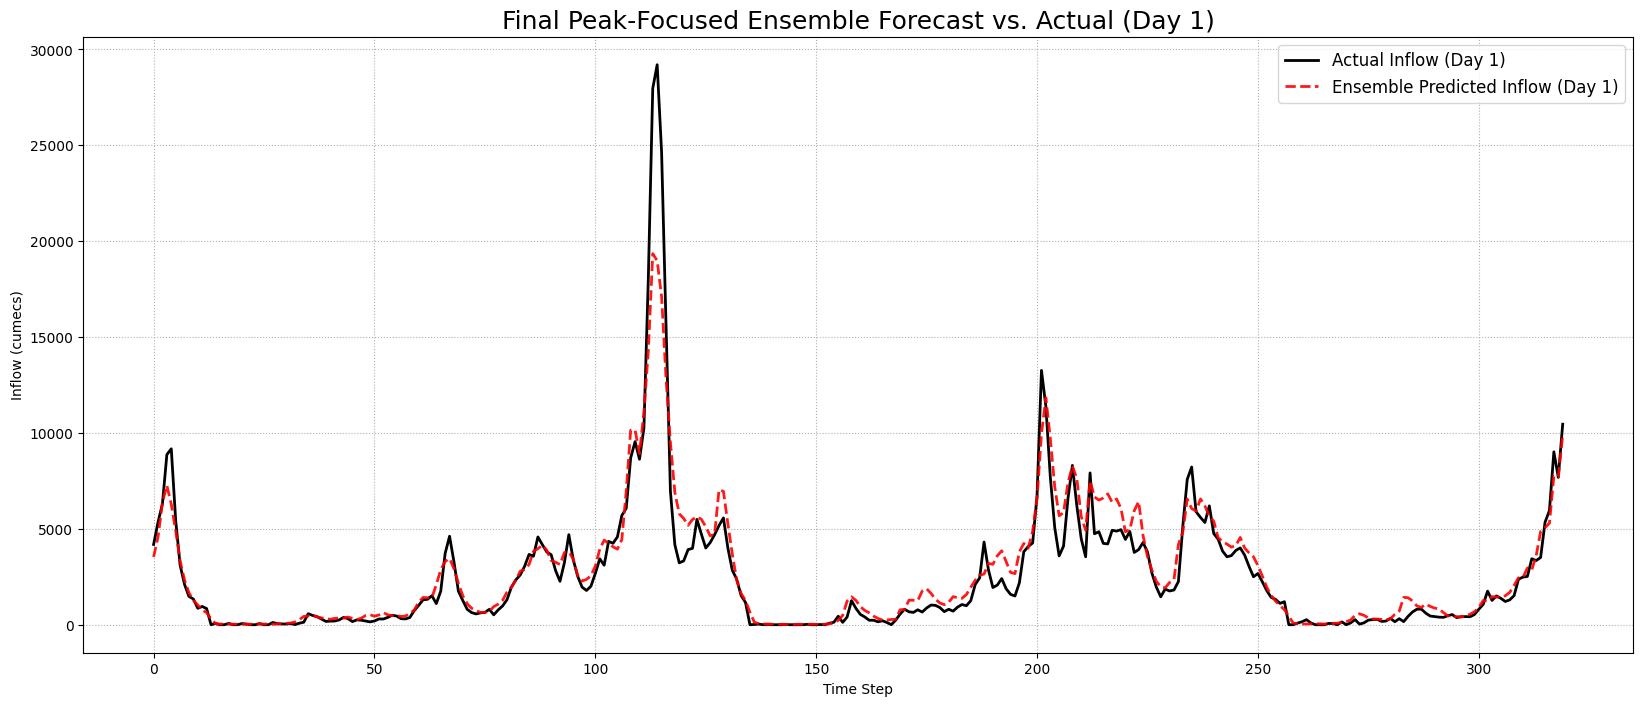

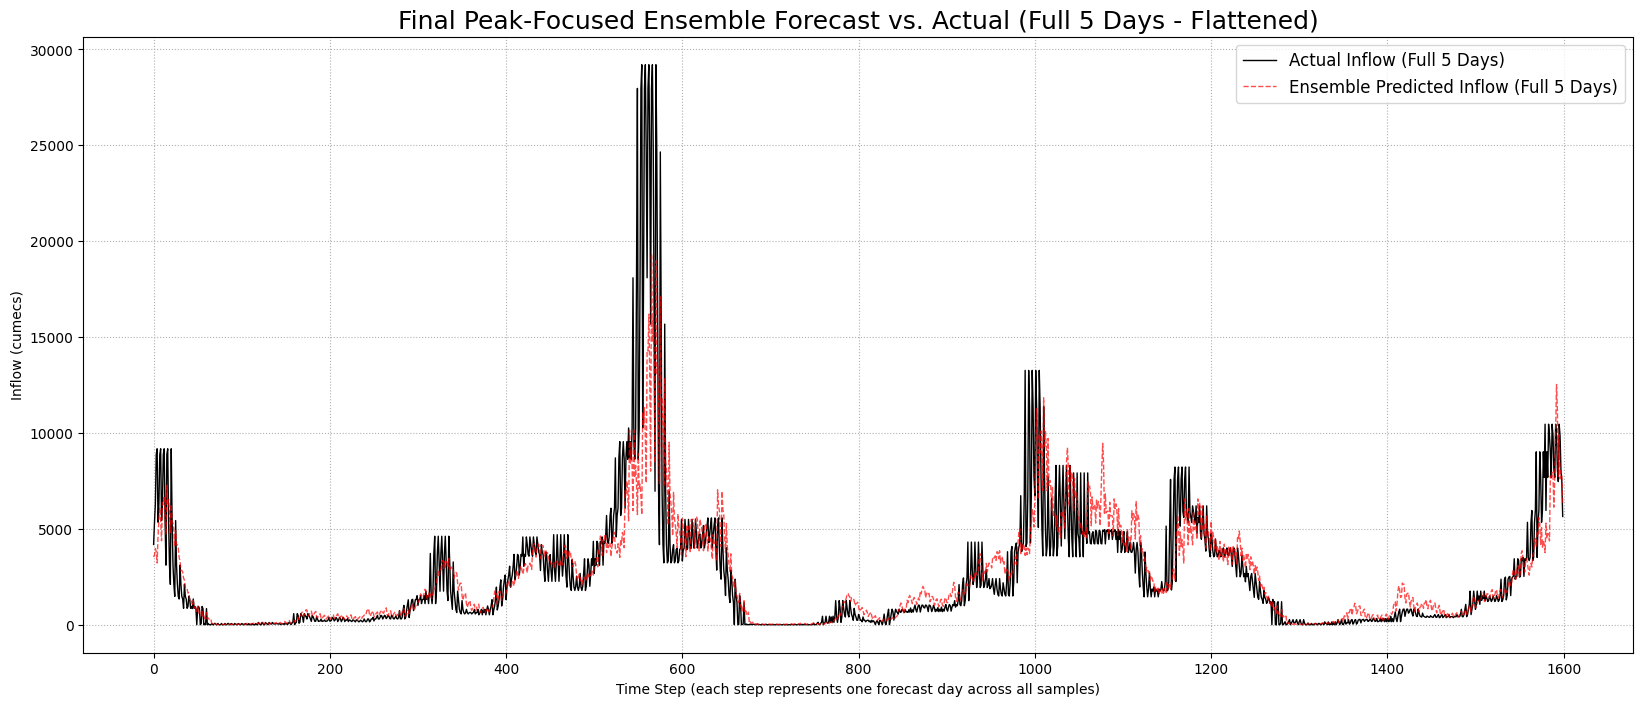

In [32]:
# Step 11: Final Voting Ensemble
print("🔄 Assembling final predictions for voting ensemble...\n")

# --- Get predictions from all models (in log space) ---
hybrid_pred_val_log = hybrid_model.predict(X_lstm_val)
hybrid_pred_test_log = hybrid_model.predict(X_lstm_test)
peak_pred_val_log = peak_cnn_bilstm_model.predict(X_peak_val)
peak_pred_test_log = peak_cnn_bilstm_model.predict(X_peak_test)

# --- Inverse transform all predictions to original scale ---
def inverse_transform_multistep(preds_log, scaler, col_idx):
    """Inverse transforms multi-step, multi-feature predictions."""
    inverted_preds = []
    for i in range(preds_log.shape[1]): # Iterate through each forecast day
        temp_array = np.zeros((preds_log.shape[0], scaler.n_features_in_))
        temp_array[:, col_idx] = preds_log[:, i]
        inverted_step = scaler.inverse_transform(temp_array)[:, col_idx]
        inverted_preds.append(np.expm1(inverted_step))
    return np.array(inverted_preds).T

inflow_idx_lstm = lstm_scaler.feature_names_in_.tolist().index('Inflow (cumecs)')
hybrid_pred_val = inverse_transform_multistep(hybrid_pred_val_log, lstm_scaler, inflow_idx_lstm)
hybrid_pred_test = inverse_transform_multistep(hybrid_pred_test_log, lstm_scaler, inflow_idx_lstm)

peak_pred_val_unscaled = peak_scaler.inverse_transform(peak_pred_val_log)
peak_pred_test_unscaled = peak_scaler.inverse_transform(peak_pred_test_log)
peak_pred_val = np.expm1(peak_pred_val_unscaled)
peak_pred_test = np.expm1(peak_pred_test_unscaled)


# --- Prepare true values on original scale ---
# This is slightly tricky because y_lstm_val_log is already subsetted to just the target
# We need to re-inflate it to the original feature space for the inverse transform
def inverse_transform_target_multistep(target_log, scaler, col_idx):
    """Inverse transforms multi-step target predictions (which are already just the target)."""
    inverted_targets = []
    # Assuming target_log shape is (n_samples, n_steps_out)
    for i in range(target_log.shape[1]): # Iterate through each forecast day
        temp_array = np.zeros((target_log.shape[0], scaler.n_features_in_))
        temp_array[:, col_idx] = target_log[:, i]
        # Inverse transform and get the target column back
        inverted_step = scaler.inverse_transform(temp_array)[:, col_idx]
        inverted_targets.append(np.expm1(inverted_step))
    return np.array(inverted_targets).T

# The y_lstm_val_log and y_lstm_test_log are already just the log-transformed target
# Need to use the original lstm_scaler to get the correct inverse transformation context
y_val_actual_multistep = inverse_transform_target_multistep(y_lstm_val_log, lstm_scaler, inflow_idx_lstm)
y_test_actual_multistep = inverse_transform_target_multistep(y_lstm_test_log, lstm_scaler, inflow_idx_lstm)


# --- Align prediction lengths ---
# Need to find the minimum length *across all models and splits* for the final ensemble
min_len_test = min(len(ml_ensemble_test), hybrid_pred_test.shape[0], peak_pred_test.shape[0])
min_len_val = min(len(ml_ensemble_val), hybrid_pred_val.shape[0], peak_pred_val.shape[0])

# Ensure actual values are also aligned to the minimum length
y_val_aligned = y_val_actual_multistep[:min_len_val]
y_test_aligned = y_test_actual_multistep[:min_len_test]


# --- Optimize voting weights on validation set ---\n",
# Make sure ML ensemble predictions are repeated 5 times to match LSTM output shape
ml_val_5d = np.repeat(ml_ensemble_val[:min_len_val].reshape(-1, 1), 5, axis=1)
hybrid_val_aligned = hybrid_pred_val[:min_len_val]
peak_val_aligned = peak_pred_val[:min_len_val]

def nse_loss(weights, y_true, p1, p2, p3):
    """Objective function to maximize NSE by minimizing its negative."""
    w1, w2, w3 = weights
    ensemble_pred = w1 * p1 + w2 * p2 + w3 * p3
    # Calculate NSE for each time step and average, or calculate for flattened array
    # Flattening is simpler and focuses on overall performance
    y_true_flat = y_true.flatten()
    ensemble_pred_flat = ensemble_pred.flatten()
    mean_observed = np.mean(y_true_flat)
    numerator = np.sum((y_true_flat - ensemble_pred_flat) ** 2)
    denominator = np.sum((y_true_flat - mean_observed) ** 2)
    # Handle case where denominator is zero (e.g., y_true is constant)
    if denominator == 0:
        return -1.0 # Return a very low NSE (high negative loss)
    nse = 1 - (numerator / denominator)
    return -nse # Minimize negative NSE = Maximize NSE


print(" optimizing voting weights on real-scale data...")
# Add small bounds epsilon to prevent division by zero in NSE calculation during optimization
bounds = [(1e-6, 1-1e-6)]*3
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

opt_result = scipy.optimize.minimize(
    fun=nse_loss,
    x0=[0.33, 0.34, 0.33],
    args=(y_val_aligned, ml_val_5d, hybrid_val_aligned, peak_val_aligned),
    method='SLSQP', # Using SLSQP which supports bounds and equality constraints
    bounds=bounds,
    constraints=constraints,
    options={'disp': True, 'maxiter': 1000}
)

opt_weights = opt_result.x
print(f"\n✅ Optimized Voting Weights: ML Ens.={opt_weights[0]:.3f}, Hybrid LSTM={opt_weights[1]:.3f}, Peak CNN-BiLSTM={opt_weights[2]:.3f}")


# --- Apply weights to test predictions ---
ml_test_5d = np.repeat(ml_ensemble_test[:min_len_test].reshape(-1, 1), 5, axis=1)
hybrid_test_aligned = hybrid_pred_test[:min_len_test]
peak_test_aligned = peak_pred_test[:min_len_test]


voting_pred_test = (opt_weights[0] * ml_test_5d +
                    opt_weights[1] * hybrid_test_aligned +
                    opt_weights[2] * peak_test_aligned)

print("\n--- Final Ensemble Evaluation ---\n")
# Evaluate on the first day of the forecast (index 0)
print("Metrics for Day 1 Forecast:")
final_metrics_day1 = calculate_metrics(y_test_aligned[:, 0], voting_pred_test[:, 0], "Final Voting Ensemble", "Test - Day 1")

# Evaluate on the entire 5-day forecast horizon flattened
print("\nMetrics for Full 5-Day Forecast (Flattened):")
final_metrics_full = calculate_metrics(y_test_aligned.flatten(), voting_pred_test.flatten(), "Final Voting Ensemble", "Test - Full 5 Days")


# --- Plot results for the first day of the forecast ---
plt.figure(figsize=(20, 8))
plt.plot(y_test_aligned[:, 0], label='Actual Inflow (Day 1)', color='black', linewidth=2)
plt.plot(voting_pred_test[:, 0], label='Ensemble Predicted Inflow (Day 1)', color='red', linestyle='--', alpha=0.9, linewidth=2)
plt.title('Final Peak-Focused Ensemble Forecast vs. Actual (Day 1)', fontsize=18)
plt.xlabel('Time Step')
plt.ylabel('Inflow (cumecs)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle=':')
plt.show()

# --- Plot results for the entire 5-day forecast flattened ---
plt.figure(figsize=(20, 8))
plt.plot(y_test_aligned.flatten(), label='Actual Inflow (Full 5 Days)', color='black', linewidth=1)
plt.plot(voting_pred_test.flatten(), label='Ensemble Predicted Inflow (Full 5 Days)', color='red', linestyle='--', alpha=0.7, linewidth=1)
plt.title('Final Peak-Focused Ensemble Forecast vs. Actual (Full 5 Days - Flattened)', fontsize=18)
plt.xlabel('Time Step (each step represents one forecast day across all samples)')
plt.ylabel('Inflow (cumecs)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle=':')
plt.show()

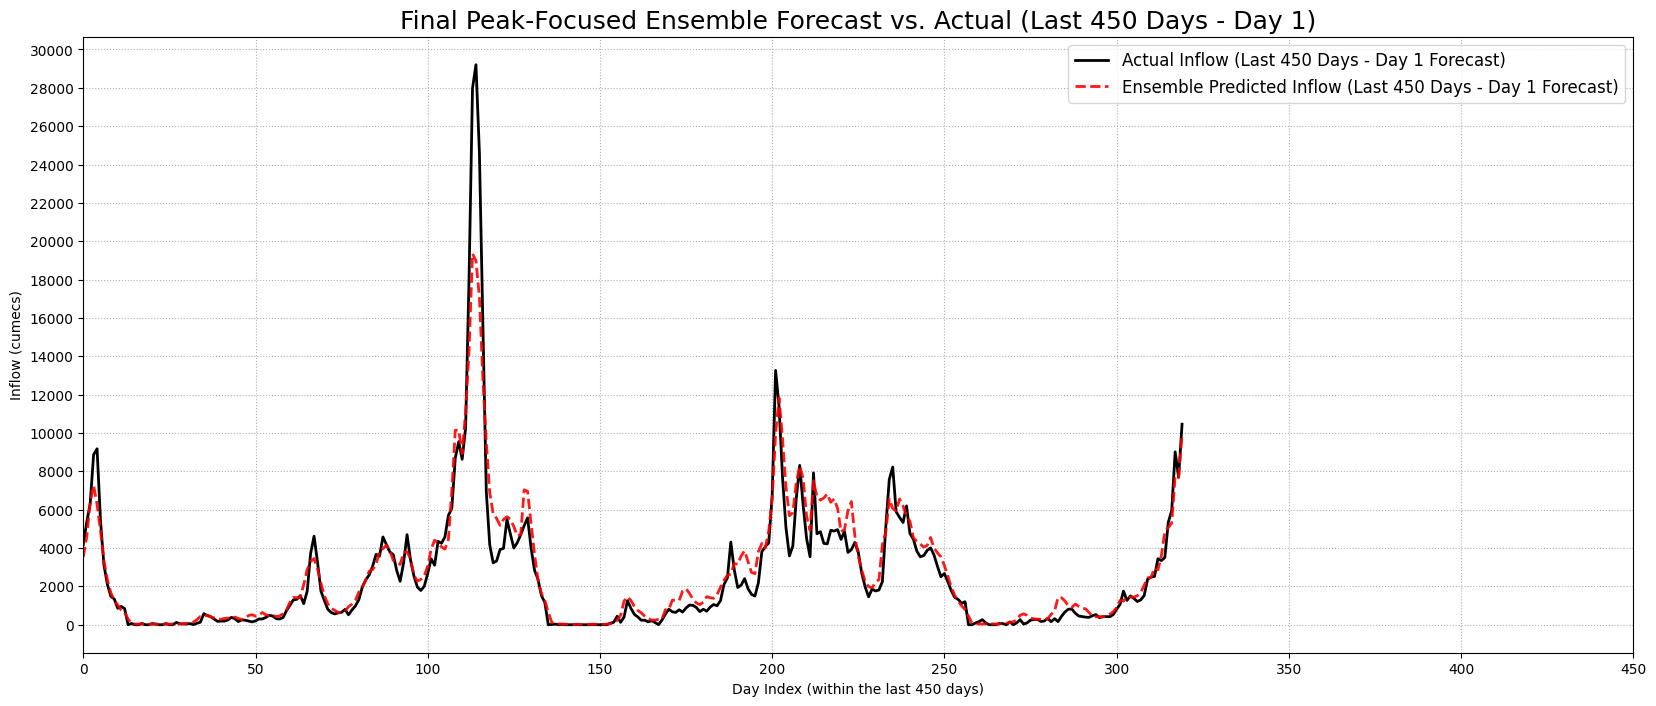

In [33]:
# Get the last 450 data points from the test set
last_450_days_actual = y_test_aligned[-450:, 0] # Using the first day of the forecast for comparison
last_450_days_predicted = voting_pred_test[-450:, 0] # Using the first day of the forecast for comparison

# Create the plot
plt.figure(figsize=(20, 8))
plt.plot(range(len(last_450_days_actual)), last_450_days_actual, label='Actual Inflow (Last 450 Days - Day 1 Forecast)', color='black', linewidth=2)
plt.plot(range(len(last_450_days_predicted)), last_450_days_predicted, label='Ensemble Predicted Inflow (Last 450 Days - Day 1 Forecast)', color='red', linestyle='--', alpha=0.9, linewidth=2)

plt.title('Final Peak-Focused Ensemble Forecast vs. Actual (Last 450 Days - Day 1)', fontsize=18)
plt.xlabel('Day Index (within the last 450 days)')
plt.ylabel('Inflow (cumecs)')
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle=':')

# Set x-axis limits and ticks
plt.xlim([0, 450])
plt.xticks(np.arange(0, 451, 50)) # Ticks from 0 to 450 with step 50

# Set y-axis ticks
# Determine appropriate y-axis limits based on data
y_max = max(np.max(last_450_days_actual), np.max(last_450_days_predicted))
plt.yticks(np.arange(0, y_max + 2000, 2000)) # Ticks starting from 0 with step 2000

plt.show()